In [18]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import string
from bs4 import BeautifulSoup
import math
from stop_words import get_stop_words


from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron


from utilidades.validar import validar
from utilidades.reducir_uso_memoria import reduce_mem_usage
from utilidades.dolarizar import dolarizar
from utilidades.dolarizar import desdolarizar
from utilidades.dolarizar import agregar_dolar_como_feature
from utilidades.generar_submit import generar_submit
from utilidades.subir_submit import subir
from utilidades.graficar import ver_dispersion


from xgboost import XGBRegressor
import lightgbm as lgb

In [7]:
ruta_data = "../data"
ruta_train = ruta_data + "/train.csv"
ruta_test = ruta_data + "/test.csv"

In [8]:
def to_ascii(s):
    car_ascii = set(string.printable)
    return "".join([a for a in s if a in car_ascii])

In [9]:
train = pd.read_csv(f"{ruta_data}/train_limpio.csv")
test = pd.read_csv(f"{ruta_data}/test_limpio.csv")

In [10]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [11]:
train = train.rename(columns={col: to_ascii(col) for col in train.columns})
test = test.rename(columns={col: to_ascii(col) for col in test.columns})

---

In [12]:
X, y = train.drop(["precio", "dia"], axis=1),train["precio"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
y_train_l = np.log(y_train)

In [32]:
y_train_l = np.log(y_train)
d_train = lgb.Dataset(X_train, label= y_train_l)
param = {
    'num_leaves': 1000,
    "objective": "fair",
    "learning_rate": 0.001,
    "num_iterations": 5000
}
reg = lgb.train(param, d_train)
pred = reg.predict(X_test)
pred = np.exp(pred)

/home/julian/.local/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [33]:
mean_absolute_error(y_test, pred)

655136.3586103622

In [ ]:
ver_dispersion(y_test, pred)

---

In [185]:
train_d = dolarizar(train)

In [186]:
X, y = train_d.drop(["precio"], axis=1),train_d["precio"]

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [188]:
y_train_l = np.log(y_train)

In [189]:
d_train = lgb.Dataset(X_train, label= y_train_l)
param = {
    'num_leaves': 450,
    "objective": "fair",
    "learning_rate": 0.01,
    "num_iterations": 1500
}
reg = lgb.train(param, d_train)
pred = reg.predict(X_test)
pred = np.exp(pred)

/home/julian/.local/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [190]:
pred = desdolarizar(X_test, pred)

In [191]:
y_test = desdolarizar(X_test, y_test)

In [192]:
mean_absolute_error(y_test, pred)

653174.8360402103

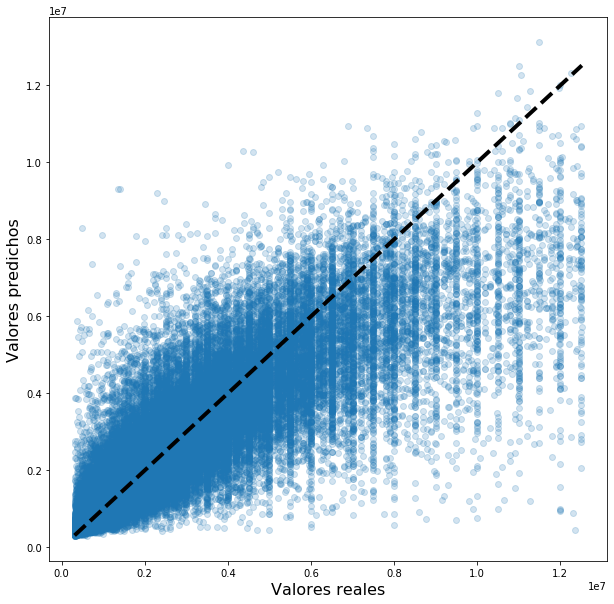

In [193]:
ver_dispersion(y_test, pred)

---

In [31]:
train_dolar_f = train.copy()
pre_dolar = pd.read_csv(f"{ruta_data}/ftr_dolar_train.csv")
train_dolar_f["precio_dolar"] = pre_dolar

In [212]:
X, y = train_dolar_f.drop(["precio"], axis=1),train_dolar_f["precio"]

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [214]:
y_train_l = np.log(y_train)

In [215]:
d_train = lgb.Dataset(X_train, label= y_train_l)
param = {
    'num_leaves': 450,
    "objective": "fair",
    "learning_rate": 0.01,
    "num_iterations": 1500
}
reg = lgb.train(param, d_train)
pred = reg.predict(X_test)
pred = np.exp(pred)

/home/julian/.local/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [216]:
mean_absolute_error(y_test, pred)

652290.8960301017

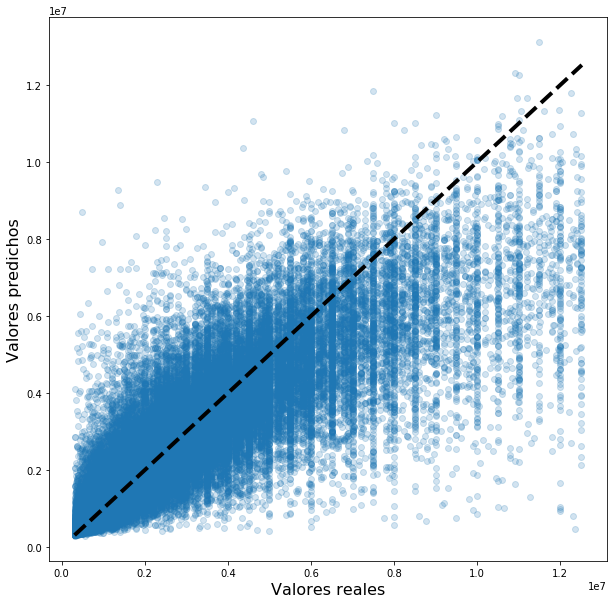

In [217]:
ver_dispersion(y_test, pred)

---

In [116]:
train_origi = pd.read_csv("data/train.csv")

test_origi = pd.read_csv("data/test.csv")

train_p = train.copy()

test_p = test.copy()

poblaciones = pd.read_csv("data/poblacion_de_cada_ciudad.csv")

poblaciones_t = pd.read_csv("data/poblacion_de_cada_ciudad_en_el_test.csv")

d_poblaciones = poblaciones.set_index("ciudad")["poblacion"].to_dict()

d_poblaciones_t = poblaciones_t.set_index("ciudad")["poblacion"].to_dict()

train_origi["ciudad"].fillna(train_origi['ciudad'].mode()[0], inplace=True)

test_origi["ciudad"].fillna(test_origi['ciudad'].mode()[0], inplace=True)

train_origi["pob_ciu"] = train_origi.apply(lambda x: d_poblaciones[x["ciudad"]], axis=1)

test_origi["pob_ciu"] = test_origi.apply(lambda x: d_poblaciones_t[x["ciudad"]], axis=1)

train_p["pob_ciu"] = train_origi["pob_ciu"]

test_p["pob_ciu"] = test_origi["pob_ciu"]

In [42]:
X, y = train_p.drop(["precio"], axis=1),train_p["precio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [43]:
y_train_l = np.log(y_train)

In [44]:
d_train = lgb.Dataset(X_train, label= y_train_l)
param = {
    'num_leaves': 450,
    "objective": "fair",
    "learning_rate": 0.01,
    "num_iterations": 1500
}
reg = lgb.train(param, d_train)
pred = reg.predict(X_test)
pred = np.exp(pred)

/home/julian/.local/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [45]:
mean_absolute_error(y_test, pred)

594684.6534104644

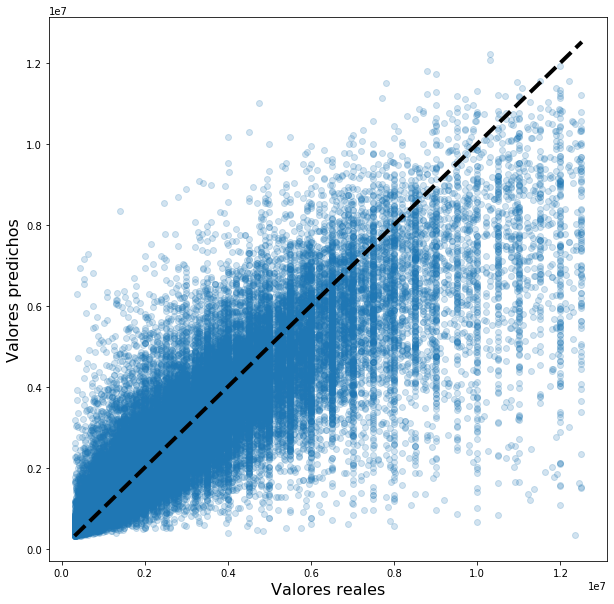

In [46]:
ver_dispersion(y_test, pred)

---

In [47]:
train_origi = pd.read_csv("data/train.csv", usecols=["descripcion"])

In [48]:
train_origi = train_origi.fillna("")

In [49]:
train_origi["descripcion"] = train_origi["descripcion"].apply(lambda x: BeautifulSoup(x, "lxml").text)

/home/julian/.local/lib/python3.7/site-packages/bs4/__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/julian/.local/lib/python3.7/site-packages/bs4/__init__.py:272: UserWarning: "b'/'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [50]:
hasher = FeatureHasher(n_features=200, input_type='string')

In [51]:
vectorized = hasher.transform(map(lambda x: x.split(), train_origi["descripcion"]))

In [52]:
descrip_vect = pd.DataFrame(vectorized.todense(), columns=[f"fh{n}" for n in range(200)])

In [53]:
train_tht = pd.concat([train_p, descrip_vect], axis=1)

In [54]:
X, y = train_tht.drop(["precio"], axis=1),train_tht["precio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [55]:
y_train_l = np.log(y_train)

In [56]:
d_train = lgb.Dataset(X_train, label= y_train_l)
param = {
    'num_leaves': 450,
    "objective": "fair",
    "learning_rate": 0.01,
    "num_iterations": 2000
}
reg = lgb.train(param, d_train)
pred = reg.predict(X_test)
pred = np.exp(pred)

/home/julian/.local/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [71]:
y_test.fillna(y_test.median())

202827     825000.0
151507     850000.0
163248    1490000.0
157083    2100000.0
69269     1663000.0
            ...    
67489      720000.0
98847     1700000.0
60402     3800000.0
137205    2500000.0
89807     1295000.0
Name: precio, Length: 79200, dtype: float64

In [64]:
min(pred), max(pred)

(0.9426033736765539, 12304158.530512663)

In [72]:
mean_absolute_error(y_test.fillna(y_test.median()), pred)

604997.2486910074

In [ ]:
ver_dispersion(y_test, pred)

---

In [23]:
test_origi = pd.read_csv("data/test.csv", usecols=["descripcion"])

In [25]:
test_origi = test_origi.fillna("")

In [26]:
test_origi["descripcion"] = test_origi["descripcion"].apply(lambda x: BeautifulSoup(x, "lxml").text)

/home/julian/.local/lib/python3.7/site-packages/bs4/__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [27]:
hasher = FeatureHasher(n_features=200, input_type='string')

In [28]:
vectorized = hasher.transform(map(lambda x: x.split(), test_origi["descripcion"]))

In [29]:
descrip_vect_t = pd.DataFrame(vectorized.todense(), columns=[f"fh{n}" for n in range(200)])

In [30]:
test_tht = pd.concat([test_p, descrip_vect_t], axis=1)

In [31]:
X, y = train_tht.drop(["precio"], axis=1),train_tht["precio"]

In [32]:
y_l = np.log(y)

In [33]:
d_train = lgb.Dataset(X, label= y_l)
param = {
    'num_leaves': 450,
    "objective": "fair",
    "learning_rate": 0.01,
    "num_iterations": 2000
}
reg = lgb.train(param, d_train)
pred = reg.predict(test_tht)
pred = np.exp(pred)

/home/julian/.local/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [34]:
pred

array([5400875.15778573, 1025288.63178568, 2250193.8151676 , ...,
        858721.75297767, 1490440.48227534, 1852276.55441314])

In [35]:
test_ori = pd.read_csv("data/test.csv", usecols=["id"])
# Generar un csv que tenga solo los ids
ids = test_ori["id"]

submit = pd.DataFrame(pred, columns=["target"])
submit.insert(0, "id", ids)
submit.to_csv(f"submits/corrida_THT_LGBM.csv", index=False)